# PREDICCIÓN DEMANDA ENERGÉTICA CALIFORNIA MENSUAL


## Importación de librerias

In [1]:
pip install sktime[all_extras]

  Using cached statsmodels-0.12.1-cp37-cp37m-manylinux1_x86_64.whl (9.5 MB)
  Using cached numpy-1.19.3-cp37-cp37m-manylinux2010_x86_64.whl (14.9 MB)
  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.9.0 requires statsmodels<=0.12.1, but you have statsmodels 0.13.1 which is incompati

In [2]:
pip install pystan==2.19.1.1

In [3]:
pip install prophet

  Using cached cmdstanpy-0.9.68-py3-none-any.whl (49 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [4]:
pip install matplotlib==3.1.3

  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
pip install --upgrade mxnet~=1.7

  Using cached mxnet-1.9.0-py3-none-manylinux2014_x86_64.whl (47.3 MB)
  Attempting uninstall: mxnet
    Found existing installation: mxnet 1.7.0.post2
    Uninstalling mxnet-1.7.0.post2:
      Successfully uninstalled mxnet-1.7.0.post2


In [6]:
pip install mxnet==1.7.0.post2

  Using cached mxnet-1.7.0.post2-py2.py3-none-manylinux2014_x86_64.whl (54.7 MB)
  Attempting uninstall: mxnet
    Found existing installation: mxnet 1.9.0
    Uninstalling mxnet-1.9.0:
      Successfully uninstalled mxnet-1.9.0


In [7]:
pip install gluonts

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.transformations.series.boxcox import LogTransformer
from sktime.utils.plotting import plot_correlations
from sktime.forecasting.ets import AutoETS
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel as _ETSModel
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
from gluonts.evaluation.backtest import make_evaluation_predictions

In [10]:
# Estas son las librerias necesarias para realizar el AMAZON DEEP AR: 
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import mxnet as mx
import numpy as np

## Lectura y Transformación del Dataset

In [11]:
# Leemos únicamente la pestaña de excel de datos diarios. La pestaña de datos horarios la dejamos para el siguiente notebook...

df_diarios = pd.read_excel("DemandaEnergia.xlsx", "Daily Data")
df_diarios

,Region,Local date,Time zone,D
0,CAL,2015-07-01,Pacific,978699
1,CAL,2015-07-02,Pacific,962751
2,CAL,2015-07-03,Pacific,887079
3,CAL,2015-07-04,Pacific,830874
4,CAL,2015-07-05,Pacific,791310
...,...,...,...,...
2340,CAL,2021-11-26,Pacific,625052
2341,CAL,2021-11-27,Pacific,622892
2342,CAL,2021-11-28,Pacific,622017
2343,CAL,2021-11-29,Pacific,698831


In [12]:
# Como podemos ver, aqui hay demasiados datos que no vamos a usar en nuestra predicción. Comenzamos quedandonos solo con las columnas Local date y D. 

df_diarios = df_diarios[["Local date", "D"]]

# Ahora que ya tenemos las columnas necesarias. Creamos un indice de serie temporal. De esta manera convertimos el data frame en una serie temporal.

df_diarios.set_index("Local date", inplace=True)
df_diarios

,D
Local date,
2015-07-01,978699
2015-07-02,962751
2015-07-03,887079
2015-07-04,830874
2015-07-05,791310
...,...
2021-11-26,625052
2021-11-27,622892
2021-11-28,622017


## Análisis de la Serie Temporal

### Evolución de la serie temporal:

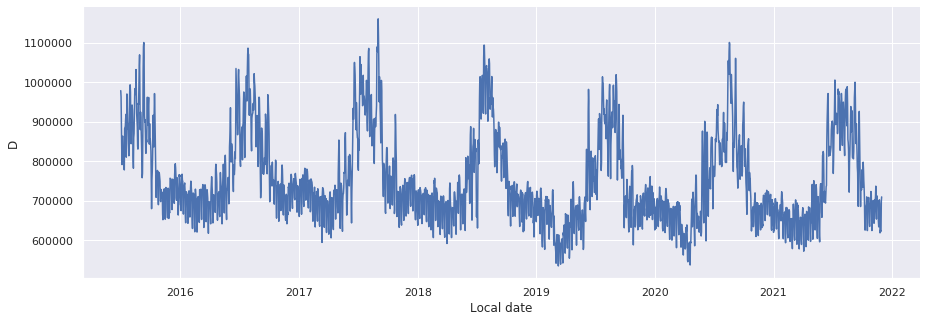

In [13]:
# Dibujamos la serie temporal en escala normal...
# Los datos aparecen en forma % porque hay picos de demanda por encima del millon. Por lo que los datos estan expresados en millones...
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.lineplot(y="D", x=df_diarios.index, data=df_diarios)
sns.despine()

### Componentes estacionales: 

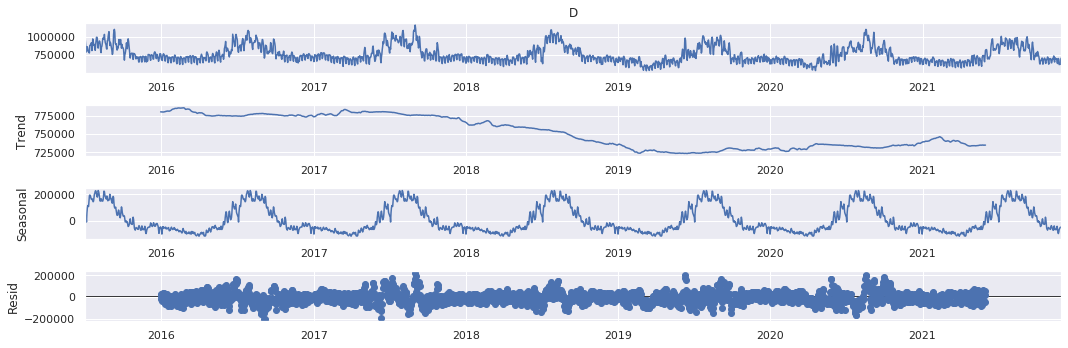

In [14]:
# Analizamos el componente estacional:
# Vemos como la serie temporal tiene una estacionalidad situandose su pico en los meses de verano y su minimo en los meses de invierno,
# la tendencia de la serie temporal es descendiente, sin embargo es apenas perceptible. 
sns.set(rc={'figure.figsize':(15,5)})
seasonal_decompose(df_diarios['D'].astype('int64'), period=365).plot() # period = dias anuales. 
plt.show()


Para realizar el análisis un poco mas exhaustivode la serie temporal, vamos a crear un nuevo dataset que incluya las columnas en años meses y dias de los consumos:

In [15]:
# Hemos querido desagragar los datos que teniamos de la serie temporal para asi poder analizar mejor la serie.
df_diarios_analisis = df_diarios
df_diarios_analisis["year"] = df_diarios_analisis.index.year
df_diarios_analisis["month"] = df_diarios_analisis.index.month
df_diarios_analisis["qtr"] = df_diarios_analisis.index.quarter
df_diarios_analisis["week"] = df_diarios_analisis.index.week
df_diarios_analisis["Media Semanal"] = df_diarios_analisis.D.rolling(7).agg(np.mean)
df_diarios_analisis["Media Mensual"] = df_diarios_analisis.D.rolling(30).agg(np.mean)
df_diarios_analisis["Media Trimestral"] = df_diarios_analisis.D.rolling(90).agg(np.mean)
df_diarios_analisis["Media Anual"] = df_diarios_analisis.D.rolling(365).agg(np.mean)
df_diarios_analisis["day"] = df_diarios_analisis.index.day
df_diarios_analisis

,D,year,month,qtr,week,Media Semanal,Media Mensual,Media Trimestral,Media Anual,day
Local date,,,,,,,,,,
2015-07-01,978699,2015,7,3,27,NaN,NaN,NaN,NaN,1
2015-07-02,962751,2015,7,3,27,NaN,NaN,NaN,NaN,2
2015-07-03,887079,2015,7,3,27,NaN,NaN,NaN,NaN,3
2015-07-04,830874,2015,7,3,27,NaN,NaN,NaN,NaN,4
2015-07-05,791310,2015,7,3,27,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...
2021-11-26,625052,2021,11,4,47,659643.571429,681329.700000,741827.500000,734498.427397,26
2021-11-27,622892,2021,11,4,47,655987.142857,677985.900000,739030.044444,734460.895890,27
2021-11-28,622017,2021,11,4,47,654319.714286,674796.300000,735627.455556,734408.882192,28


In [16]:
df_diarios = df_diarios[["D"]]
df_diarios

,D
Local date,
2015-07-01,978699
2015-07-02,962751
2015-07-03,887079
2015-07-04,830874
2015-07-05,791310
...,...
2021-11-26,625052
2021-11-27,622892
2021-11-28,622017


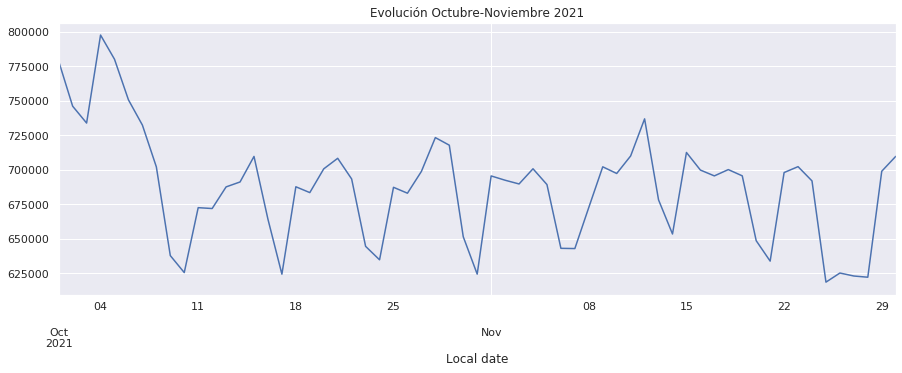

In [17]:
df_diarios_analisis[(df_diarios_analisis["month"]>9) & (df_diarios_analisis["year"]==2021)]["D"].plot(title="Evolución Octubre-Noviembre 2021")

### Analisis Trend:

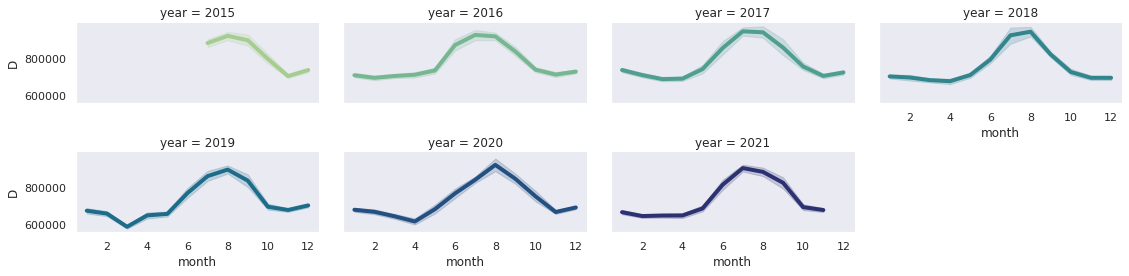

In [18]:
# Vemos la evolución de la demanda electrica diaria por años. Nos ha parecido bastante interesante mostrar como evoluciona el consumo a lo 
# largo de los años y sus comparativas. El dibujo de la curva a lo largo de los años es prácticamente el mismo, salvo en los años 2019 y 2020,
# en el que aparecen diferentes 'outliers'. 
sns.set_theme(style="dark")
g = sns.relplot(
    data=df_diarios_analisis,
    x="month", y="D", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=10,
    col_wrap=4, height=2, aspect=2, legend=False,
)

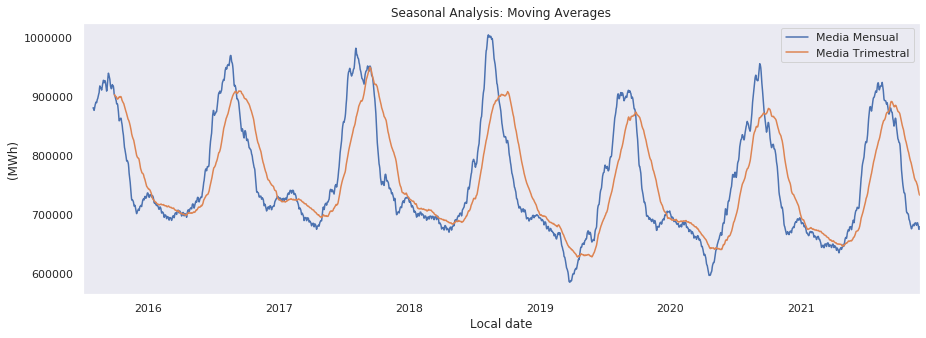

In [19]:
# Vemos en el plot como la media trimestral tiene menos desviaciones que la media mensual, lo apreciamos asi por la suavidad de la curva.
df_diarios_analisis[["Media Mensual", "Media Trimestral"]].plot(title="Seasonal Analysis: Moving Averages")
plt.ylabel("(MWh)")
plt.show()

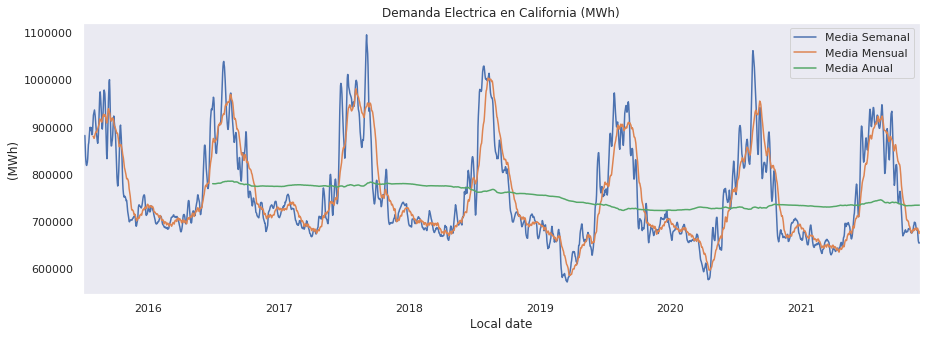

In [20]:
# Al igual que en el gráfico anterior, vemos como las curvas,a medida que se realizan las medias mas grandes se suavizan mas, hasta acabar
# con la curva de la media anual en la que podemos ver el trend de la serie. Igual en el gráfico de descomposición el descenso del trend
# se veia mas abrupto pero aqui se ve realmente que la bajada es muy poca. La serie practicamente no tiene tendencia. 
df_diarios_analisis[["Media Semanal", "Media Mensual", "Media Anual"]].plot(title="Demanda Electrica en California (MWh)")
plt.ylabel("(MWh)")
plt.show()

### Análisis de la distribución de los datos:

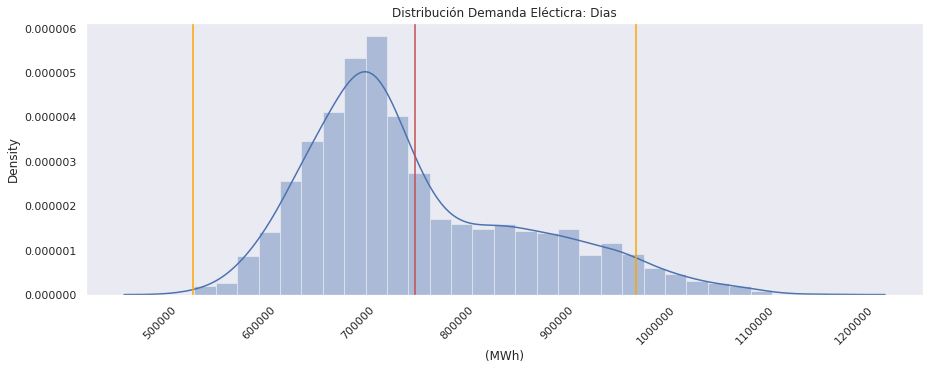

In [21]:
# La distribución de los datos sigue una Poisson asimétrica positiva(Hay mas datos hacia la derecha de la media.). 
mean = np.mean(df_diarios_analisis.D)
std = np.std(df_diarios_analisis.D)
sns.distplot(df_diarios_analisis.D)
plt.title("Distribución Demanda Elécticra: Dias")
plt.xticks(rotation=45)
plt.xlabel("(MWh)")
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
plt.show()

### Análisis de los Outliers:

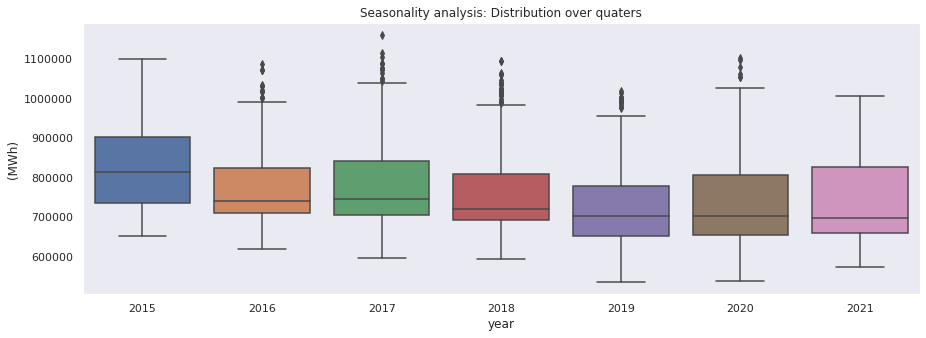

In [22]:
# Los diagramas de caja nos muestran que la mediana de los valores practicamente no se ha movido en los ultimos tres años. 
# En 2021 no hemos encontrado valores atipicos superiores lo que no encaja con los datos de la distribución previamente realizada.
# (Recordamos que era asimetrica positiva, por lo que tenemos que tener mas outliers por encima como de los periodos 2016-2020). 
# Si nos fijamos en los valores de la mediana, otra vez podemos observar la tendencia de la serie, decreciente. 
sns.boxplot(data=df_diarios_analisis, x="year", y="D")
plt.title("Seasonality analysis: Distribution over quaters")
plt.ylabel("(MWh)")
plt.show()

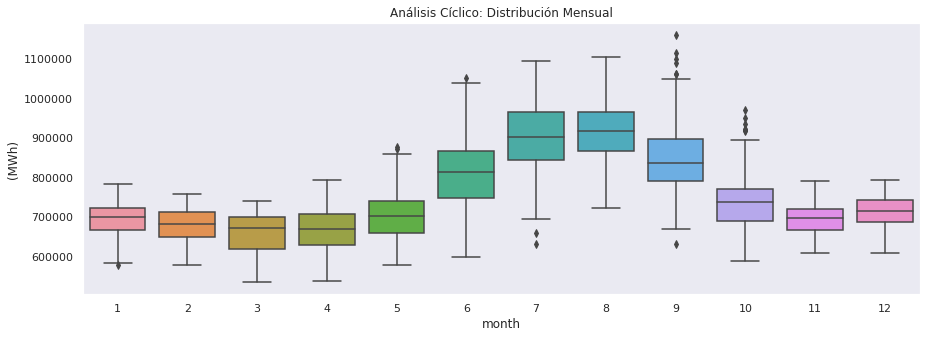

In [23]:
# Una vez mas vemos la distribución de datos de la serie temporal a lo largo del año. de este gráfico podemos sacar que el mes que mayor
# número de outliers tiene es el mes de Septiembre y octubre.  Destacamos el de septiembre porque es el unico que tiene outliers en los dos
# extremos. Podemos decir que es el mes con mas volatilidad de demanda. 
sns.boxplot(data=df_diarios_analisis, x="month", y="D")
plt.title("Análisis Cíclico: Distribución Mensual")
plt.ylabel("(MWh)")
plt.show()

## Separación entre Train y Test

Eleguimos una proporción de 15 dias de test, esto lo hacemos para testear las dos semanas previas a la predicción que tenemos que realizar. 

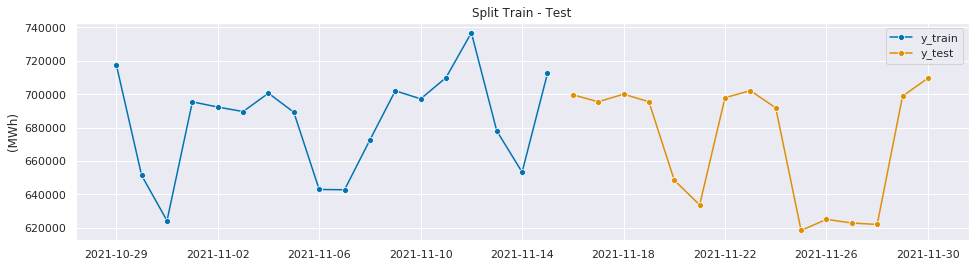

In [24]:
y_train, y_test = temporal_train_test_split(y = df_diarios['D'].astype('float64').to_period('d'), test_size=15)

# Dibujamos la serie dividida entre train y test, en este caso, acortamos train para poder ver mejor la evolución del train:
sns.set(rc={'figure.figsize':(8,5)})
plot_series(y_train[-18:], y_test, labels=["y_train", "y_test"])
plt.title("Split Train - Test")
plt.ylabel("(MWh)")
plt.show()

## Transformación de los datos en escala logaritmica: 

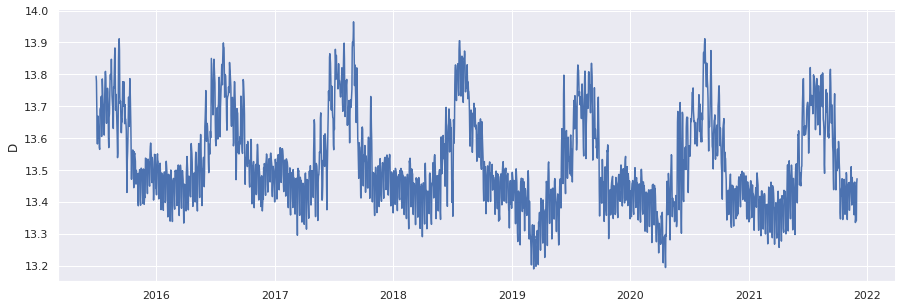

In [25]:
# Transformamos la serie en escala logaritmica: 
transformer = LogTransformer()
df_diarios_log = transformer.fit_transform(df_diarios)

# Dibujamos la serie temporal en escala logaritmica...
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.lineplot(y="D", x=df_diarios_log.index, data=df_diarios_log)
sns.despine()

## Separación entre train y test

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f909d44a890>)

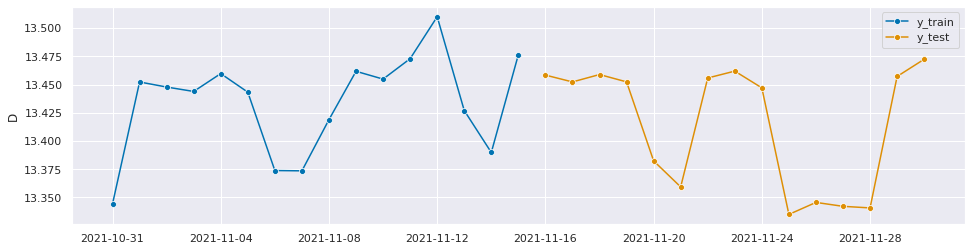

In [26]:
y_train_log, y_test_log = temporal_train_test_split(y = df_diarios_log['D'].astype('float64').to_period('d'), test_size=15)

# Dibujamos la serie dividida entre train y test, en este caso, acortamos train para poder ver mejor la evolución del train:
sns.set(rc={'figure.figsize':(8,5)})
plot_series(y_train_log[-16:], y_test_log, labels=["y_train", "y_test"])

## Análisis de las correlacciones: 

(<Figure size 864x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f909c6921d0>,
       dtype=object))

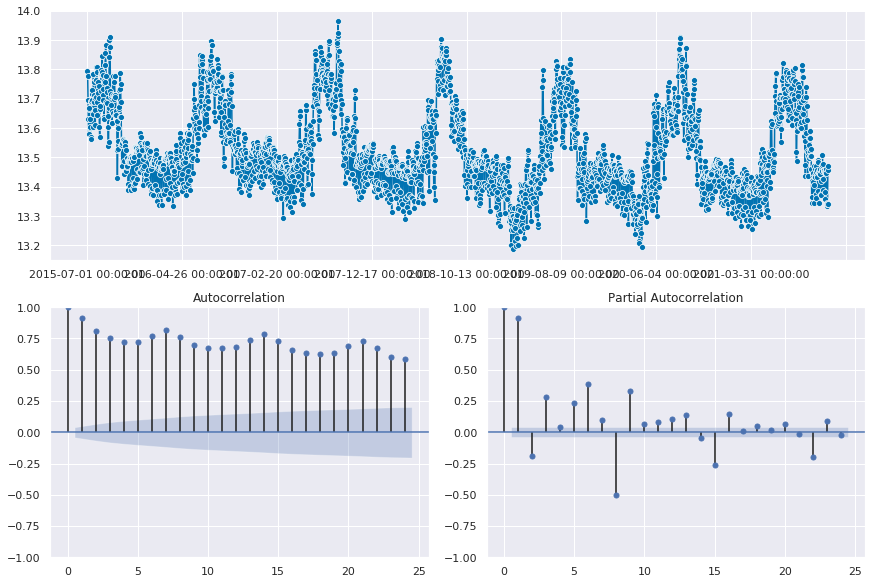

In [27]:
plot_correlations(df_diarios_log)

## Métodos sencillos de predicción:

### Método Naive de la media

Escogemos el método simple de la media ya que la serie no tiene apenas tendencia. Esta si que tiene estacionalidad pero apenas percibo tendencia, así que puede ser un método de predicción ingenuo bastante apropiado para esta serie temporal.

MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): 
                  R2_score    MAPE        RMSE         MAE
Modelo                                                    
Naive Bayes Mean   -0.5859  0.0519  44505.7288  34610.7444
---
GRÁFICO PREDICCIONES: 


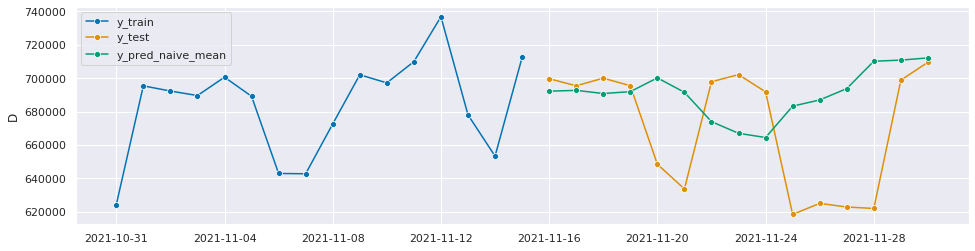

In [28]:
# Definimos el horizonte temporal: 
fh = ForecastingHorizon(np.arange(len(y_test)) + 1, is_relative=True)

# Definimos el predictor: 
naive_mean = NaiveForecaster(strategy="mean", sp=365) #sp = 365. ya que tenemos los datos en diario

#Ajustamos el modelo:
naive_mean.fit(y_train)

#Predecimos:
y_pred_naive_mean = naive_mean.predict(fh)

#Dibujamos el modelo: 
plot_series(y_train[-16:], y_test, y_pred_naive_mean, labels=["y_train", "y_test", "y_pred_naive_mean"])

#Mostramos los errores del modelo de predicción: 
rmse = MeanSquaredError(square_root=True)
Errores = pd.DataFrame({
    "Modelo": ["Naive Bayes Mean"],
    "R2_score": [round(r2_score(y_test,y_pred_naive_mean),4)],
    "MAPE": [round(mean_absolute_percentage_error(y_test,y_pred_naive_mean),4)],
    "RMSE": [round(rmse(y_test,y_pred_naive_mean),4)],
    "MAE": [round(mean_absolute_error(y_test,y_pred_naive_mean),4)]
})

Errores = Errores.set_index("Modelo")

print("MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): ")
print(Errores)
print("---")
print("GRÁFICO PREDICCIONES: ")

Las predicciones del modelo no se adaptan bien a la serie temporal. Vemos en el gráfico como la linea temporal falla sobre todo prediciendo los descensos de demanda. 

Respecto a los errores que hemos obtenido, el mas determinante es el R2_score, que compara el fit del modelo con el de una linea horizontal (hipotesis nula), al ser este negativo no podemos rechazar la hippotesis nula y por lo tanto determinamos que nuestro modelo se adapta peor que una linea horizontal. 

El MAPE que obtenemos es de un 5.19% es decir, las desviaciones que obtenemos de predicción son de entorno al 5.20% de un rango de 700.000 a 620.000€. Lo complementamos con el MAE que son 34610€ y el RMSE, que es mayor debido a lo que hemos comentado previamente, nuestro modelo no detecta los picos de bajada de demanda. 

### Método Naive Estacional.

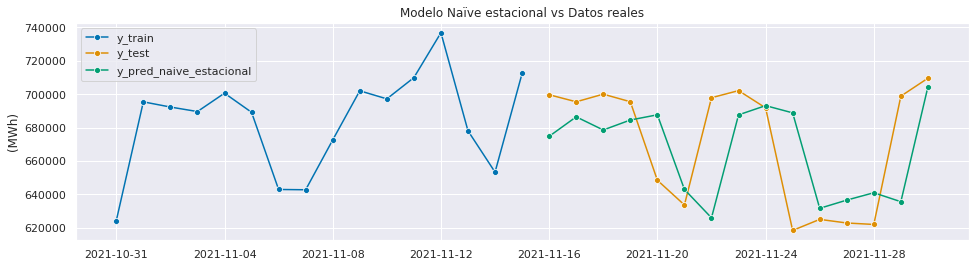

MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): 
                        R2_score    MAPE        RMSE         MAE
Modelo                                                          
Naive Bayes Mean         -0.5859  0.0519  44505.7288  34610.7444
Naive Bayes Estacional    0.0471  0.0382  34497.8786  25376.3333
---
GRÁFICO PREDICCIONES: 


In [29]:
# Definimos el horizonte temporal: 
fh = ForecastingHorizon(np.arange(len(y_test)) + 1, is_relative=True)

# Definimos el predictor: 
naive_last = NaiveForecaster(strategy="last", sp=365) #ya que tenemos los datos en diario

#Ajustamos el modelo:
naive_last.fit(y_train)

#Predecimos:
y_pred_naive_last= naive_last.predict(fh)

#Dibujamos el modelo: 
plot_series(y_train[-16:], y_test, y_pred_naive_last, labels=["y_train", "y_test","y_pred_naive_estacional"])
plt.title("Modelo Naïve estacional vs Datos reales")
plt.ylabel("(MWh)")
plt.show()

#Mostramos los errores del modelo de predicción: 
rmse = MeanSquaredError(square_root=True)

Errores.loc["Naive Bayes Estacional"] = [round(r2_score(y_test,y_pred_naive_last),4),
                                   round(mean_absolute_percentage_error(y_test,y_pred_naive_last),4),
                                   round(rmse(y_test,y_pred_naive_last),4),
                                   round(mean_absolute_error(y_test,y_pred_naive_last),4)]

print("MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): ")
print(Errores)
print("---")
print("GRÁFICO PREDICCIONES: ")

En el modelo Naive estacional encontramos una mejor predicción. Aqui, como podemos observar en el grafico, el modelo si que reacciona a las bajadas e demanda. La predicción sigue una trazada similar pero, igual con 1 periodo de retraso, sobre todo a partir del periodo 5 de predicción. 

En cuanto al R2 score vemos como este es de un 4%, si bien es cierto que es un porcentaje pequeño, nos indica que la aplicación de este modelo rechaza la hipótesis nula. 

EL error de la predicción del modelo con respecto a los valores reales es de 25.376€. Lo que supone un MAPE de 3%. 

Mantendremos este modelo 'tonto' como modelo base, para comparar sus estimaciones con el resto de modelos que utilicemos. 

## Modelo ETS

                                 ETS Results                                  
Dep. Variable:                      D   No. Observations:                 2330
Model:                       ETS(MNM)   Log Likelihood              -26981.664
Date:                Thu, 20 Jan 2022   AIC                          53999.329
Time:                        15:11:28   BIC                          54102.894
Sample:                    07-01-2015   HQIC                         54037.063
                         - 11-15-2021   Scale                            0.001
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.024     41.067      0.000       0.952       1.048
smoothing_seasonal   5.635e-05        nan        nan        nan         nan         nan
initial_level   

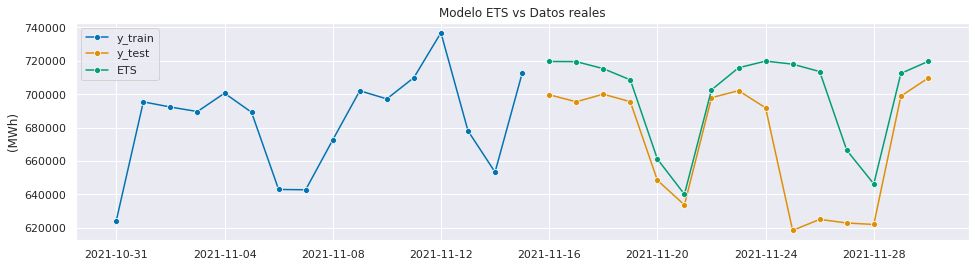

MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): 
                        R2_score    MAPE        RMSE         MAE
Modelo                                                          
Naive Bayes Mean         -0.5859  0.0519  44505.7288  34610.7444
Naive Bayes Estacional    0.0471  0.0382  34497.8786  25376.3333
ETS                      -0.2322  0.0412  39230.2850  27819.0465
---
GRÁFICO PREDICCIONES: 


In [30]:
# Definimos el horizonte temporal: 
fh = ForecastingHorizon(np.arange(len(y_test)) + 1, is_relative=True)

# Definimos el predictor:
ets_model = AutoETS(auto=True, sp=14, njobs=-1)

# Ajustamos el modelo:
ets_model.fit(y_train)

# Mostramos el modelo obtenido: 
print(ets_model.summary())
print("---")
# Predecimos:
y_pred_ets_model = ets_model.predict(fh)

# Dibujamos el modelo: 
plot_series(y_train[-16:], y_test, y_pred_ets_model, labels=["y_train", "y_test","ETS"])
plt.title("Modelo ETS vs Datos reales")
plt.ylabel("(MWh)")
plt.show()

# Mostramos los errores del modelo de predicción: 
rmse = MeanSquaredError(square_root=True)

Errores.loc["ETS"] = [round(r2_score(y_test,y_pred_ets_model),4),
                      round(mean_absolute_percentage_error(y_test,y_pred_ets_model),4),
                      round(rmse(y_test,y_pred_ets_model),4),
                      round(mean_absolute_error(y_test,y_pred_ets_model),4)]

print("MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): ")
print(Errores)
print("---")
print("GRÁFICO PREDICCIONES: ")

Hemos tenido problemas para la implementación de este modelo. Al introducirle una estacionalidad, sp de 365, el modelo no cargaba de manera correcta. por lo que nos hemos visto forzados a meter una estacionalidad de 7 dias. Por ello, las predicciones del modelo no son del todo acertadas situandose no solo debajo de las predicciones de nuestro modelo base (Naive Bayes estacional) sino que la aplicación del propio modelo no rechaza la hipotesis nula teniendo un r2 negativo. 

## Modelo ARIMA 

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2330
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 14)   Log Likelihood                4633.018
Date:                            Thu, 20 Jan 2022   AIC                          -9252.037
Time:                                    15:27:56   BIC                          -9211.764
Sample:                                         0   HQIC                         -9237.363
                                           - 2330                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1579      0.019     61.281      0.000       1.121       1.195
ar.L2         -0.3764      0.015   

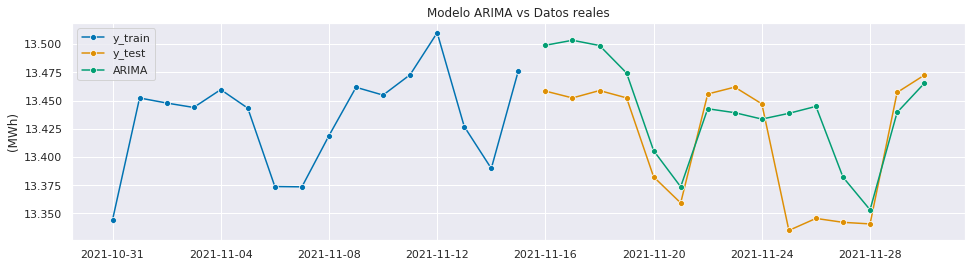

MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): 
                        R2_score    MAPE        RMSE         MAE
Modelo                                                          
Naive Bayes Mean         -0.5859  0.0519  44505.7288  34610.7444
Naive Bayes Estacional    0.0471  0.0382  34497.8786  25376.3333
ETS                      -0.2322  0.0412  39230.2850  27819.0465
ARIMA                     0.2712  0.0347  30170.9844  23417.0045
---
GRÁFICO PREDICCIONES: 


In [31]:
# Definimos el horizonte temporal: 
fh = ForecastingHorizon(np.arange(len(y_test_log)) + 1, is_relative=True)

# Definimos el predictor:
arima_model = AutoARIMA(sp=14,suppress_warnings=True)

# Ajustamos el modelo:
arima_model.fit(y_train_log)

# Mostramos el resumen del modelo obtenido:
print(arima_model.summary())
print("---")

# Predecimos: 
y_pred_arima_model = arima_model.predict(fh)

# Dibujamos el modelo: 
plot_series(y_train_log[-16:], y_test_log, y_pred_arima_model, labels=["y_train", "y_test","ARIMA"])
plt.title("Modelo ARIMA vs Datos reales")
plt.ylabel("(MWh)")
plt.show()

# Cambiamos la escala de las predicciones a NO logaritmica:
y_pred_arima_model = np.exp(y_pred_arima_model)

# Mostramos los errores del modelo de predicción: 
rmse = MeanSquaredError(square_root=True)

Errores.loc["ARIMA"] = [round(r2_score(y_test,y_pred_arima_model),4),
                        round(mean_absolute_percentage_error(y_test,y_pred_arima_model),4),
                        round(rmse(y_test,y_pred_arima_model),4),
                        round(mean_absolute_error(y_test,y_pred_arima_model),4)]

print("MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): ")
print(Errores)
print("---")
print("GRÁFICO PREDICCIONES: ")

Obtenemos el mismo problema que con el ets, fijamos el horizonte en 7 dias (semanal) ya que fijarlo en 365 es imposible de ejecutar. 

Al realizar el autoarima sobre la serie temporal, obtenemos un modelo autoregresivo en dos periodos, con media movil 1, y dependiente de los errores pasados. A su vez, este posee un componente autoregresivo sin media movil pero dependiente de los errores pasados. 

Este modelo si mejora a nuestro modelo base, podemos ver como nuestro r2 es mayor (rechaza hipotesis nula) y nuestro mape es ligeramente menor. EL rmse quiza en comparativa con el modelo de Naive es algo mayor, (nos fijamos proporcion mae rmse) esto puede deberse a las predicciones del modelo de los puntos 9 a 13. Donde la predicción del modelo no se termina de ajustar...


## Modelo PROPHET

Para realizar el prophet debemos cambiar la forma de nuestro train y test, debemos disponer de los datos de la columna de fechas asi como de la columna de consumo de electricidad. Cambiamos el train y test. 

In [32]:
df_diarios_prophet = df_diarios.reset_index()
df_diarios_prophet = df_diarios_prophet.rename(columns={"index":"ds","D":"y"})

prophet_train = df_diarios_prophet.iloc[:2329,:]
prophet_test = df_diarios_prophet.iloc[2330:,:]

MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): 
                        R2_score    MAPE        RMSE         MAE
Modelo                                                          
Naive Bayes Mean         -0.5859  0.0519  44505.7288  34610.7444
Naive Bayes Estacional    0.0471  0.0382  34497.8786  25376.3333
ETS                      -0.2322  0.0412  39230.2850  27819.0465
ARIMA                     0.2712  0.0347  30170.9844  23417.0045
PROPHET                   0.3208  0.0261  29124.8068  17245.5181
---
GRAFICO DEL MODELO: 


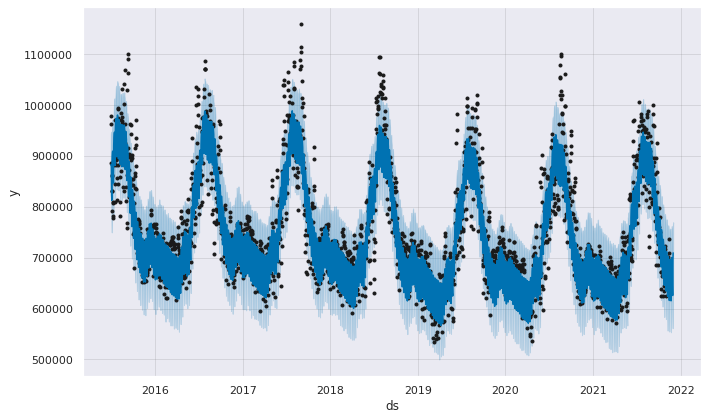

---
DESCOMPOSICIÓN DEL MODELO: 


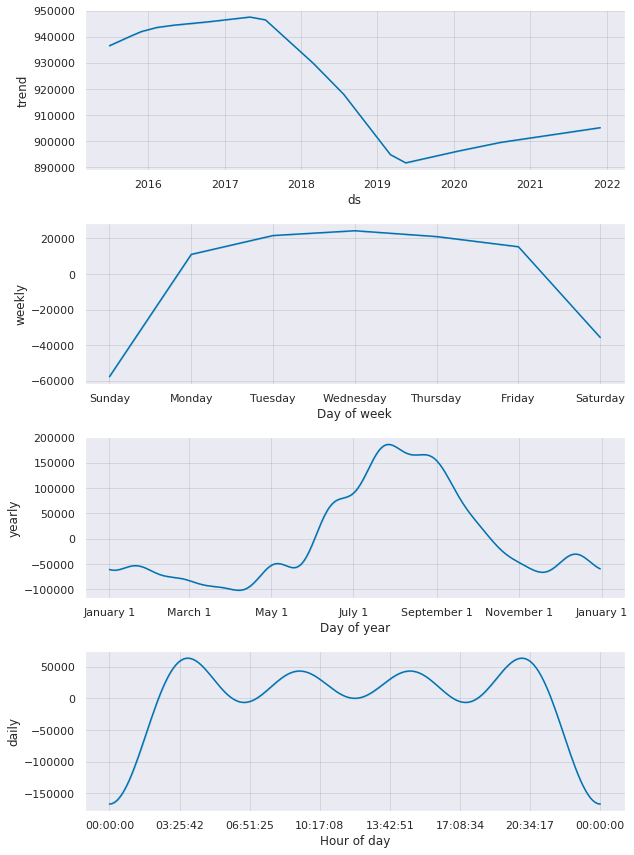

---
GRÁFICO PREDICCIONES vs REALIDAD: 


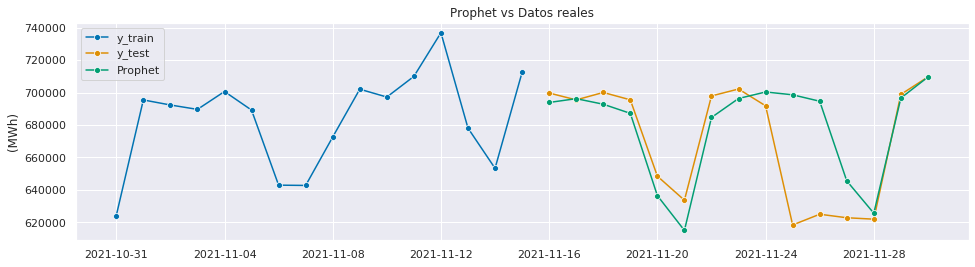

In [33]:
# Definimos el horizonte temporal: 
fh = (len(prophet_test) + 1)

# Definimos el predictor:
prophet_model = Prophet(daily_seasonality=True)

# Ajustamos el modelo:
prophet_model.fit(prophet_train)


# Predecimos: 
fh_prophet = prophet_model.make_future_dataframe(periods=fh)
y_pred_prophet_model = prophet_model.predict(fh_prophet)

# Mostramos los errores del modelo de predicción:
rmse = MeanSquaredError(square_root=True)

Errores.loc["PROPHET"] = [round(r2_score(y_test,y_pred_prophet_model["yhat"].tail(15)),4),
                          round(mean_absolute_percentage_error(y_test,y_pred_prophet_model["yhat"].tail(15)),4),
                          round(rmse(y_test,y_pred_prophet_model["yhat"].tail(15)),4),
                          round(mean_absolute_error(y_test,y_pred_prophet_model["yhat"].tail(15)),4)]


print("MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): ")
print(Errores)
print("---")
print("GRAFICO DEL MODELO: ")

# Dibujamos el grafico del predict:
fig1 = prophet_model.plot(y_pred_prophet_model)
plt.show()
print("---")
print("DESCOMPOSICIÓN DEL MODELO: ")
fig2 = prophet_model.plot_components(y_pred_prophet_model)
plt.show()

print("---")
print("GRÁFICO PREDICCIONES vs REALIDAD: ")

# Dibujamos el modelo: 
y_pred_prophet_model.set_index("ds", inplace=True)
y_pred_prophet_model.index = y_pred_prophet_model.index.to_period("D")
plot_series(y_train[-16:], y_test, y_pred_prophet_model["yhat"].tail(15), labels=["y_train", "y_test","Prophet"])
plt.title("Prophet vs Datos reales")
plt.ylabel("(MWh)")
plt.show()

Con el prophet obtenemos unas predicciones muy parecidas a las de nuestro modelo ARIMA. Sin embargo, son mejoradas sobre todo si nos fijamos en la prediccion de los primeros puntos. 

Nuestro R2 es de un 32%, algo bastante aceptable, quiza nos sigue fallando la prediccion entre los periodos 9 y 13 y por ello obtenemos un mayor rmse. 


## Modelo AMAZON DEEP AR

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 10/10 [00:00<00:00, 13.76it/s, epoch=1/5, avg_epoch_loss=15.4]
INFO:gluonts.trainer:Epoch[0] Elapsed time 0.732 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=15.382294
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 10/10 [00:00<00:00, 16.99it/s, epoch=2/5, avg_epoch_loss=14.8]
INFO:gluonts.trainer:Epoch[1] Elapsed time 0.602 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=14.782469
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 10/10 [00:00<00:00, 17.42it/s, epoch=3/5, avg_epoch_loss=14.2]
INFO:gluonts.trainer:Epoch[2] Elapsed time 0.580 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=14.189199
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 10/10 [00:00<00:00, 16.97it/s, epoch=4/5, avg_epoch_loss=13.3]
INFO:gluonts.trainer:Epoch[3] Elapsed time

MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): 
                        R2_score    MAPE        RMSE         MAE
Modelo                                                          
Naive Bayes Mean         -0.5859  0.0519  44505.7288  34610.7444
Naive Bayes Estacional    0.0471  0.0382  34497.8786  25376.3333
ETS                      -0.2322  0.0412  39230.2850  27819.0465
ARIMA                     0.2712  0.0347  30170.9844  23417.0045
PROPHET                   0.3208  0.0261  29124.8068  17245.5181
AMAZON DEEP AR            0.1013  0.0377  33502.9380  25039.6625
---
GRAFICO DE PREDICCIONES vs REALIDAD: 


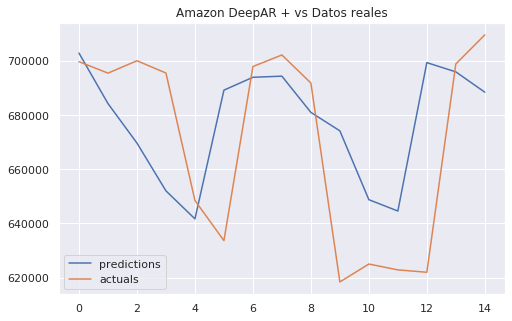

In [34]:
# Ajustamos el formato de los datos para que puedan ser usados por gluonts:
from gluonts.dataset.common import ListDataset

df_diarios_amazon = df_diarios.reset_index()
df_diarios_amazon = df_diarios_amazon.rename(columns={"index":"date","D":"y"})

start = pd.Timestamp("01-07-2015", freq="D")

train_ds = ListDataset([{'target': df_diarios_amazon.loc[:2329,'y'], 'start': start}], freq='D')
test_ds = ListDataset([{'target': df_diarios_amazon['y'], 'start': start}],freq='D')

# Establecemos una semilla para que, al realizar la red neuronal obtengamos siempre el mismo resultado: 
np.random.seed(15)
mx.random.seed(15)

# Establecemos el modelo: 
estimator = DeepAREstimator(prediction_length=15, #Numero de periodos a predecir.
                            context_length=7, #Es el numero de periodos en los que se va a fijar el modelo(coger pocos)
                            freq='D', #Tipo de frecuencia de la predicción.
                            trainer=Trainer(epochs=5, #Numero de vueltas
                                            learning_rate=1e-3, #tasa de aprencizaje
                                            num_batches_per_epoch=10), #hemos bajado este parametro que suele estar entre (10-100). 
                            num_layers = 2, #Numero de neuronas empleadas. (Entre 1-4). 
                            num_cells = 45) #Numero de capas por cada neurona (Entre 40 y 90). 

predictor = estimator.train(train_ds)

# Realizamos las predicciones: 
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

# Obtenemos los errores del modelo: 
Errores.loc["AMAZON DEEP AR"] = [round(r2_score(y_test,predictions),4),
                                 round(mean_absolute_percentage_error(y_test,predictions),4),
                                 round(rmse(y_test,predictions),4),
                                 round(mean_absolute_error(y_test,predictions),4)]

print("MOSTRAMOS LOS ERRORES DE LOS MODELOS (comparativa): ")
print(Errores)
print("---")

# Dibujamos el modelo:

print("GRAFICO DE PREDICCIONES vs REALIDAD: ")
plt.plot(predictions)
plt.plot(list(test_ds)[0]['target'][-15:])
plt.legend(['predictions', 'actuals'])
plt.title("Amazon DeepAR + vs Datos reales")
plt.show()

Realizamos un modelo de Amazon de redes neuronales para ver si se puede adaptar mejor a la serie temporal propuesta. Especialmente buscamos mejorar las predicciones de los periodos de prediccion 9 y 13, pero no hemos conseguido mejoras globales con respecto a otros modelos. 

Se han probado diversos parametros, pero no hemos conseguido que la predicción sea del todo satisfactoria. No obstante, obtenemos un modelo por encima de nuestro modelo base marcado (Naive Bayes).



## Predicciones: 

Con los medidas de los modelos obtenidas y su comparativa, hemos determinado que el mejor modelo para la predicción del consumo diario de energia en California es el modelo Prophet, ahora realizamos las predicciones de los 15 primeros dias de diciembre de 2021: 

VALORES DE PREDICCIÓN OBTENIDOS: 
             ds           yhat
0    2015-07-01  882118.210048
1    2015-07-02  881083.361885
2    2015-07-03  878237.588009
3    2015-07-04  830639.998599
4    2015-07-05  812341.005537
...         ...            ...
2355 2021-12-11  669156.089325
2356 2021-12-12  647673.029391
2357 2021-12-13  716582.067443
2358 2021-12-14  726872.627933
2359 2021-12-15  728976.221684

[2360 rows x 2 columns]


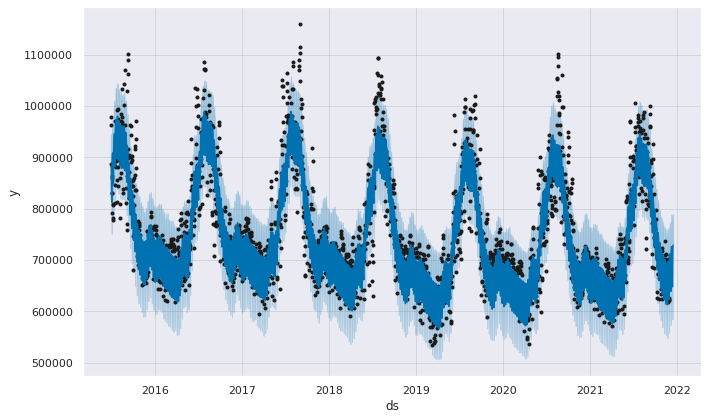

In [35]:
# Definimos el horizonte temporal, en este caso, los 15 primeros dias de diciembre: 
fh = 15

# Definimos el predictor:
prophet_model = Prophet(daily_seasonality=True)

# Ajustamos el modelo:
prophet_model.fit(df_diarios_prophet)

# Predecimos: 
fh_prophet = prophet_model.make_future_dataframe(periods=fh)
y_pred_prophet_model = prophet_model.predict(fh_prophet)

# Imprimimos los valores obtenidos:
print("VALORES DE PREDICCIÓN OBTENIDOS: ")
print(y_pred_prophet_model[["ds", "yhat"]])


# Dibujamos el grafico del predict:
fig1 = prophet_model.plot(y_pred_prophet_model)
plt.show()

In [36]:
# Guardamos nuestras predicciones en csv: 
predictions_december_daily = y_pred_prophet_model[["ds", "yhat"]]
predictions_december_daily.to_csv('predictions_december_daily', index = False)

In [37]:
# Comprobamos que están bien guardados los datos: 

df = pd.read_csv('predictions_december_daily')
df

,ds,yhat
0,2015-07-01,882118.210048
1,2015-07-02,881083.361885
2,2015-07-03,878237.588009
3,2015-07-04,830639.998599
4,2015-07-05,812341.005537
...,...,...
2355,2021-12-11,669156.089325
2356,2021-12-12,647673.029391
2357,2021-12-13,716582.067443
2358,2021-12-14,726872.627933
